# **Projet 10** : Détecter des faux billets avec Python

## **Objectifs :** 

Lutter contre le faux-monnayage en mettant en place un modèle permettant d'identifier les vrais et faux billets.

- Effectuer une régression linéaire ou multiple pour combler les valeurs manquantes dans nos données
- Utiliser 2 modèles de prédictions pour détecter les faux billets : méthode des k-means et régression logistique
- Selectionner le modèle le plus performant

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Modèles et algorithmes
from scipy.stats import shapiro, t, probplot
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, silhouette_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols

# Sauvegarde du modèle
from joblib import dump, load

In [2]:
# Données à dispostion

df = pd.read_csv("billets.csv", sep=";")

In [3]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
# Affiche le nombre de valeurs uniques
df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [5]:
print("Nombre de vrais / faux billets : ", df['is_genuine'].value_counts())

Nombre de vrais / faux billets :  is_genuine
True     1000
False     500
Name: count, dtype: int64


In [6]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Notre dataframe **df** contient : 
- **1500 billets**, un par ligne :
     - **1000 VRAIS** billets
     - **500 FAUX** billets
- **7 variables** différentes :
    - la variable **"is_genuine"** de type booléen pour spécifier **l'authenticité d'un billet** (True ou False)
    - **6 autres variables numériques (Float)** indiquant les mesures et dimensions des billets

In [7]:
# Affiche le nombre de valeurs manquantes
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il manque **37** valeurs dans la colonne **'margin_low'**.


Ces **valeurs manquantes** seront traitées à l'aide d'une **regression linéaire** simple ou multiple, cela reste à déterminer.

Au vue du nombre de variables que contient le dataframe et de leur relation potentielle entre elles (dimensions, mesures), nous partiront sur **la régression linéaire multiple**.

In [8]:
# Transformer la colonne 'is_genuine' en valeur numérique
df['is_genuine'] = df['is_genuine'] * 1

df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


**'is_genuine'** est converti en valeur numérique avec **1 = Vrai**, **0 = Faux**.

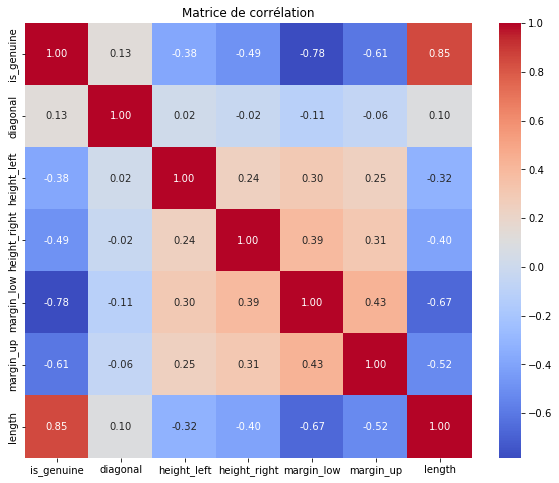

In [9]:
# Analysons la corrélation entre 'margin_low' et les autres variables
# pour déterminer notre choix entre une régression linéaire simple ou multiple 

# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Tracer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

**'margin_low'** semble montrer des corrélations significatives avec plusieurs variables : **'is_genuine'**, **'length'** (corrélation négative forte) et **'margin_up'** (corrélation positive assez forte). 

Nous retiendrons **la régression linéaire multiple** pour prédire les valeurs manquantes de **'margin_low'** tout en prétant attention à la possibilité d'une multicollinéarité.

In [10]:
#df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
#df.head()

### Regression linéaire multiple

Nous retirerons du modèle **chaque variable ayant une P-valeur >0,05** car elles ne sont **pas statistiquement significative**, en commençant par la plus élevée.

Elles n'ont **aucun impact** sur la **prédiction de 'margin_low'**.

In [12]:
def backward_elimination(data, response, p_value_threshold=0.05):
    features = data.columns.drop(response)
    while len(features) > 0:
        features_to_test = '+'.join(features)
        formula = f"{response} ~ {features_to_test}"
        model = ols(formula, data=data).fit()

        # Excluer l'intercept des résultats p-value
        p_values = model.pvalues.drop('Intercept')

        max_p_value = p_values.max()
        if max_p_value >= p_value_threshold:
            excluded_feature = p_values.idxmax()
            features = features.drop(excluded_feature)
            print(f"\nVariable exclue : {excluded_feature} avec p-value {max_p_value:.4f}")
            print(f"Variables restantes : {features.to_list()}\n")
        else:
            break
    
    final_features_to_test = '+'.join(features)
    final_formula = f"{response} ~ {final_features_to_test}"
    final_model = ols(final_formula, data=data).fit()
    
    return final_model

model = backward_elimination(df, 'margin_low')
print(model.summary())


Variable exclue : length avec p-value 0.8685
Variables restantes : ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up']


Variable exclue : diagonal avec p-value 0.7191
Variables restantes : ['is_genuine', 'height_left', 'height_right', 'margin_up']


Variable exclue : height_right avec p-value 0.4960
Variables restantes : ['is_genuine', 'height_left', 'margin_up']


Variable exclue : height_left avec p-value 0.4544
Variables restantes : ['is_genuine', 'margin_up']

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Thu, 08 Feb 2024   Prob (F-statistic):          1.24e-304
Time:                        20:46:13   Log-Likelihood:                -774.73
No. Observations:                146

Après avoir **simplifier le modèle de regression linéaire multiple** et **améliorer sa précision**, nous gardons uniquement les variables : **'margin_up'** et **'is_genuine'** pour **prédire les valeurs manquantes de 'margin_low'**.

### Analyse des résidus 

L'analyse des résidus est **cruciale dans la modélisation de régression** car elle permet **d'évaluer la qualité de l'ajustement du modèle aux données** et **d'identifier d'éventuelles violations des hypothèses** de la régression linéaire.

In [13]:
# Reprenons notre régression linéaire multiple 

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Thu, 08 Feb 2024   Prob (F-statistic):          1.24e-304
Time:                        20:46:13   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

In [14]:
# Nous allons ici réaliser les tests à un niveau 𝛼 = 5%

alpha = 0.05

# Récupérons n, le nombre d'individus de l'échantillon, et p, le nombre de variables.
# Ainsi que n_obs, le nombre d'observations

n = df.shape[0]
n_obs = model.nobs
p = 3

Nous allons mener des analyses sur **les valeurs atypiques et/ou influentes** en travaillant sur un dataframe appelé  **analyses**.

In [15]:
analyses = pd.DataFrame({'obs':np.arange(1, n_obs+1)})

#### Calcul des leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

- Les observations avec des valeurs de levier élevées sont celles qui ont une influence disproportionnée sur l'ajustement du modèle.
- Comme règle générale, une valeur de levier qui dépasse le seuil est considérée comme potentiellement influente.
- Si nous identifions des observations avec un levier élevé, nous voudrons peut-être les examiner de plus près pour déterminer si elles sont des valeurs aberrantes ou si elles exercent une influence indue sur le modèle.

In [16]:
analyses['levier'] = model.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

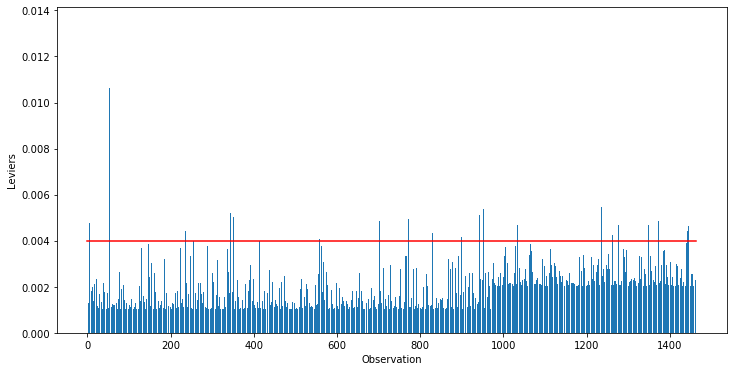

In [17]:
plt.figure(figsize=(12,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, n_obs, step=200))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n_obs], [seuil_levier, seuil_levier], color='r')
plt.show()

#### Calcul des résidus studentisés

Les résidus studentisés sont une version standardisée des résidus qui permettent de détecter des observations qui ont un comportement anormal par rapport à l'ajustement du modèle.

Si l'on souhaite maintenant les calculer, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté

In [18]:
analyses['rstudent'] = model.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

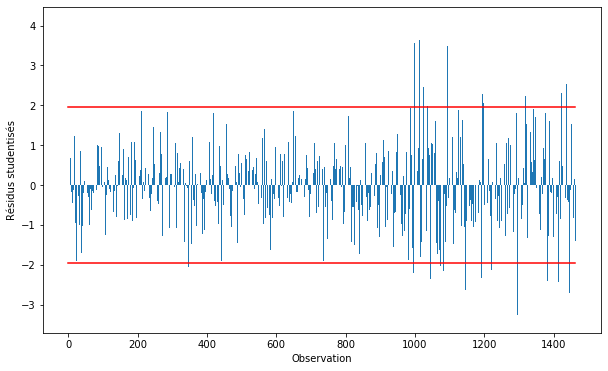

In [19]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n_obs, step=200))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n_obs], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n_obs], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

**Différences intrinsèques** : Si les faux billets ont des caractéristiques géométriques qui diffèrent systématiquement des vrais billets, les résidus pour ces observations pourraient naturellement être plus élevés.

**Modèle sous-spécifié** : Le modèle peut ne pas inclure toutes les variables pertinentes qui expliquent 'margin_low' pour les faux billets. Il peut y avoir d'autres facteurs non mesurés ou non inclus qui influencent 'margin_low' différemment pour les faux billets.

**Échantillon hétérogène** : Si les faux billets constituent un échantillon hétérogène avec une plus grande variance dans les caractéristiques mesurées, cela peut également entraîner des résidus plus élevés car le modèle est basé sur des moyennes et pourrait ne pas bien saisir cette variabilité.

#### Calcul de la distance de Cook


Cela aide à identifier les points de données qui, s'ils étaient supprimés, mèneraient à un changement significatif dans les estimations des coefficients de régression. C'est un moyen de détecter les valeurs aberrantes qui peuvent potentiellement biaiser ou fausser les résultats de la régression.

In [20]:
influence = model.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p. 

In [21]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

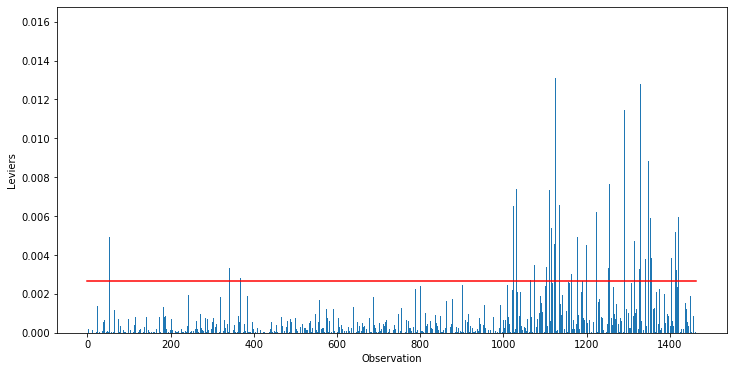

In [22]:
plt.figure(figsize=(12,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n_obs, step=200))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n_obs], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [23]:
# Identifier les observations qui dépassent le seuil de la distance Cook
obs_outliers = analyses[analyses['dcooks'] > seuil_dcook].index

print("Nombre d'observations jugées aberrantes : ", len(obs_outliers))

Nombre d'observations jugées aberrantes :  98


In [24]:
# Créer un nouveau DataFrame sans les observations jugées aberrantes
df_no_outliers = df.drop(obs_outliers)

df_no_outliers.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [25]:
model_no_outliers = backward_elimination(df_no_outliers, 'margin_low')
print(model_no_outliers.summary())


Variable exclue : height_left avec p-value 0.8763
Variables restantes : ['is_genuine', 'diagonal', 'height_right', 'margin_up', 'length']


Variable exclue : height_right avec p-value 0.4133
Variables restantes : ['is_genuine', 'diagonal', 'margin_up', 'length']


Variable exclue : diagonal avec p-value 0.3347
Variables restantes : ['is_genuine', 'margin_up', 'length']

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     972.4
Date:                Thu, 08 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:46:18   Log-Likelihood:                -456.26
No. Observations:                1365   AIC:                             920.5
Df Residuals:                    1361   BIC:                             

In [26]:
# Calcul du VIF pour notre modèle sans valeurs aberrantes

variables_no_outliers = model_no_outliers.model.exog
[variance_inflation_factor(variables_no_outliers, i) for i in np.arange(1,variables_no_outliers.shape[1])]

[4.197559048160783, 1.5995260035869914, 3.6366382941040523]

In [27]:
# Test de l'homoscédsticité sans les valeurs jugées aberrantes 

_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(model_no_outliers.resid, variables_no_outliers)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 5.388522376900482e-11


In [28]:
# Prédiction des valeurs manquantes pour 'margin_low' dans df_no_outliers

X_missing = df_no_outliers[df_no_outliers['margin_low'].isnull()][['is_genuine', 'margin_up', 'length']]
y_pred_missing = model_no_outliers.predict(X_missing)

# Remplissage des valeurs manquantes avec les prédictions
df_no_outliers.loc[df_no_outliers['margin_low'].isnull(), 'margin_low'] = y_pred_missing

# Affichage des valeurs manquantes qui ont été remplacées par les prédictions
filled_values_no_outliers = df_no_outliers.loc[X_missing.index, 'margin_low']
print(filled_values_no_outliers)

72      4.062237
99      4.096943
151     4.114637
197     4.008437
241     4.089989
251     4.141283
284     4.087889
334     4.137262
410     4.095352
413     4.087291
445     4.118382
481     4.222941
505     4.153832
611     4.054324
654     4.173065
675     4.222032
710     4.092454
739     4.078045
742     4.076360
780     4.113228
798     4.181949
844     4.138844
845     4.168655
871     4.119265
895     4.161184
919     4.235731
945     4.108151
946     4.053450
981     4.139709
1076    5.235991
1121    5.266537
1176    5.249196
1303    5.263872
1315    5.215867
1347    5.087930
1435    5.148167
1438    5.213513
Name: margin_low, dtype: float64


In [29]:
df_no_outliers.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000
mean,0.703281,171.960749,104.018666,103.906434,4.439411,3.141491,112.734979
std,0.456975,0.305328,0.299565,0.323618,0.596222,0.224091,0.844416
min,0.000000,171.040000,103.140000,102.820000,3.120000,2.560000,109.490000
25%,0.000000,171.750000,103.810000,103.690000,4.010000,2.980000,112.180000
50%,1.000000,171.960000,104.030000,103.900000,4.290000,3.130000,113.000000
75%,1.000000,172.170000,104.220000,104.140000,4.810000,3.300000,113.360000
max,1.000000,173.010000,104.880000,104.950000,6.540000,3.810000,114.440000


#### Vérifier la colinéarité des variables

In [30]:
variables = model.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007746]

Ici, tous les coefficients sont **inférieurs à 10**, il n'y a donc **pas de problème de colinéarité**.

#### Test de l’homoscédasticité

Vérifions **l'homoscédasticité** (c'est-à-dire la constance de la variance) de nos résidus avec le **test de Breusch-Pagan**

Nos hypothèses sont les suivantes : 

- Hypothèse nulle (***H0***) : Il n'y a **pas d'hétéroscédasticité** (c'est-à-dire, la variance des résidus est constante).
- Hypothèse alternative (***H1***) : Il y a de l'**hétéroscédasticité** (c'est-à-dire, la variance des résidus varie avec les niveaux de la variable indépendante ou les prédictions).

In [31]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(model.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.203355911585938e-36


In [32]:
# Prédiction des valeurs manquantes pour 'margin_low' dans df

X_missing = df[df['margin_low'].isnull()][['is_genuine', 'margin_up']]
y_pred_missing = model.predict(X_missing)

# Remplissage des valeurs manquantes avec les prédictions
df.loc[df['margin_low'].isnull(), 'margin_low'] = y_pred_missing

# Affichage des valeurs manquantes qui ont été remplacées par les prédictions
filled_values = df.loc[X_missing.index, 'margin_low']
print(filled_values)

72      4.074248
99      4.097561
151     4.122994
197     3.995830
241     4.122994
251     4.137830
284     4.078487
334     4.127233
410     4.101800
413     4.093322
445     4.125114
481     4.188696
505     4.131472
611     4.063651
654     4.190815
675     4.220487
710     4.112397
739     4.108158
742     4.076367
780     4.099681
798     4.125114
844     4.129352
845     4.148427
871     4.112397
895     4.131472
919     4.216248
945     4.122994
946     4.070009
981     4.129352
1076    5.245925
1121    5.254403
1176    5.286194
1303    5.305269
1315    5.205657
1347    5.161149
1435    5.171746
1438    5.239567
Name: margin_low, dtype: float64


In [33]:
df.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482863,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659849,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Les **2 modèles de régression linéaire multiple** présentent des **prédictions sur 'margin_low' très similaire**, je décide de garder le dataframe le plus complet et son modèle avec les observations ayant des résultats qui pourraient être jugés comme aberrant mais avec une multicollinéarité plus faible.

## Analyse univariée

Après avoir examiné les résidus de notre modèle de régression et noté certaines déviations mineures de la normalité, il pourrait être bénéfique d'explorer davantage les relations entre nos variables en procédant à une analyse univariée.

In [34]:
# Aperçu des données

df.sample(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1241,0,171.66,104.17,104.02,4.71,3.22,110.91
136,1,172.06,104.19,103.59,4.39,3.22,113.69
16,1,171.30,104.19,103.70,4.12,2.82,112.87
1386,0,172.05,104.22,104.05,5.87,3.18,111.13
736,1,171.69,103.85,103.53,3.86,3.19,112.68
446,1,172.51,104.53,103.50,4.51,3.07,113.21
191,1,171.86,104.70,103.62,4.01,3.34,112.89
985,1,171.88,103.87,104.02,4.12,3.33,112.47
1205,0,171.92,103.90,104.58,5.56,3.50,110.59
132,1,171.84,103.77,103.98,4.61,2.99,113.59


In [35]:
# Informations sur notre Dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


In [36]:
# Description synthétique des données 

df.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482863,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659849,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Les **données** semblent **homogènes**. 

**Les moyennes et les médianes** de chaque variable sont **proches des valeurs minimales et maximales**.

In [37]:
# Affiche la moyenne et la médiane des variables pour les vrais et faux billets

df.groupby('is_genuine').agg({'mean', 'median'}).round(3).stack()

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                      
0          median   171.910      104.180       104.160       5.195      3.350   
           mean     171.901      104.190       104.144       5.216      3.350   
1          median   171.990      103.950       103.810       4.112      3.050   
           mean     171.987      103.949       103.809       4.116      3.052   

                    length  
is_genuine                  
0          median  111.630  
           mean    111.631  
1          median  113.205  
           mean    113.202

**'margin_low'** présente une **différence de médiane** bien **plus importante** que les autres variables.

Observons ces différences à l'aide plusieurs graphiques. (distribution, dispersion, paires de variables)

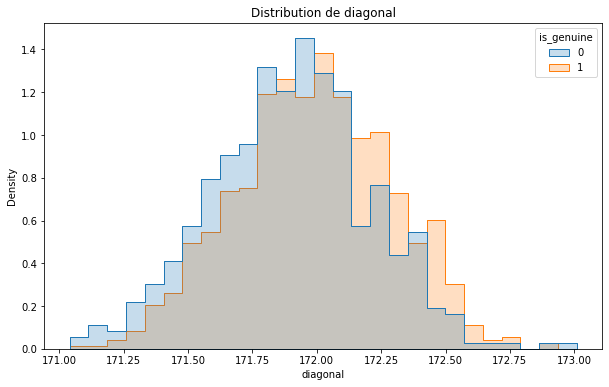

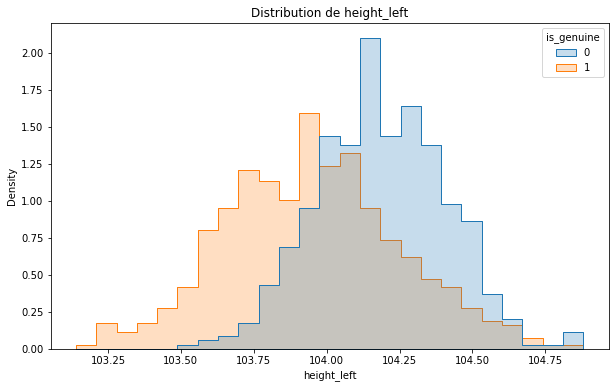

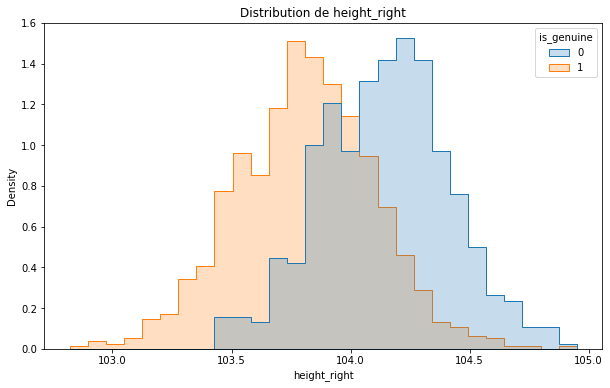

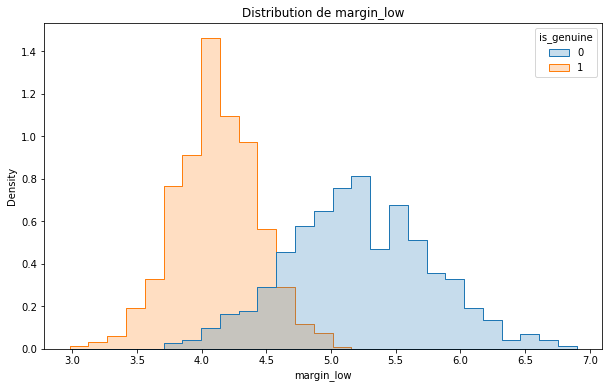

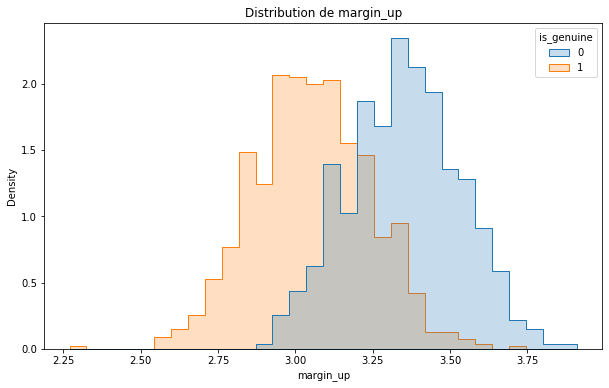

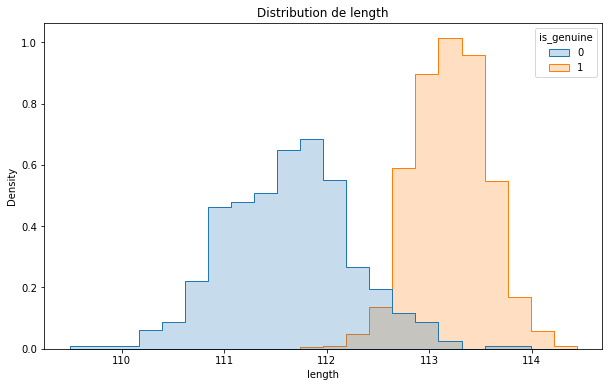

In [38]:
# Distribution des variables 

columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

for col in columns:
    plt.figure(figsize=(10,6))
    sns.histplot(df, x=col, hue='is_genuine', element="step", stat="density", common_norm=False)
    plt.title(f'Distribution de {col}')
    plt.show()

**'length'** et **'margin_low'** semblent montrer, par leur distribution, des **caractéristiques discrimantes** pour distinguer les vrais et faux billets.

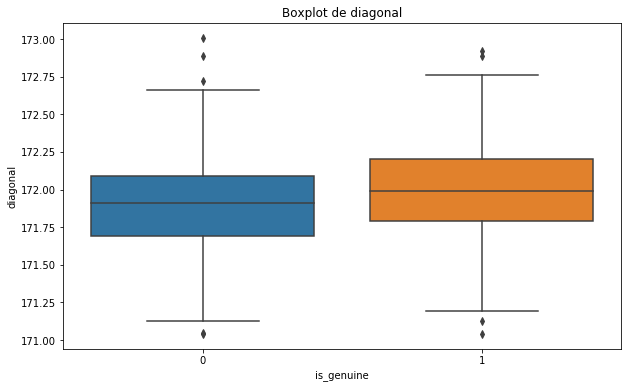

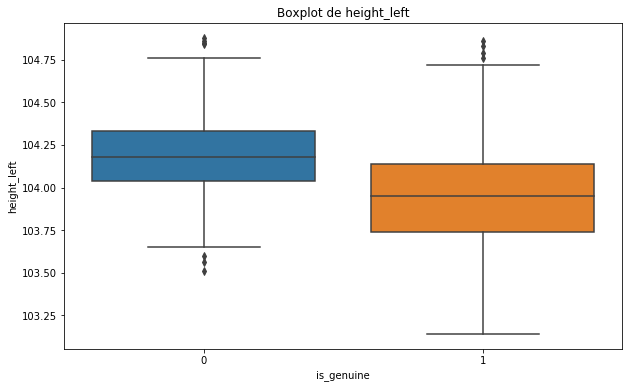

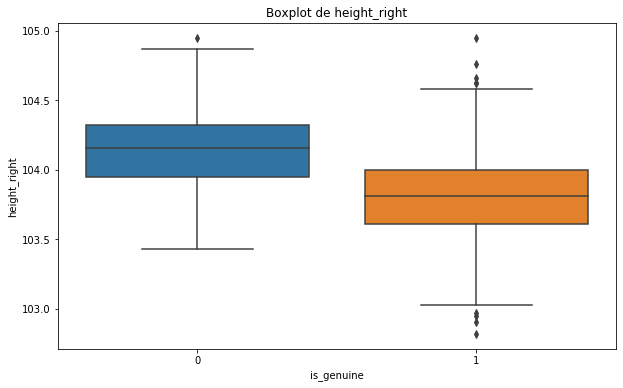

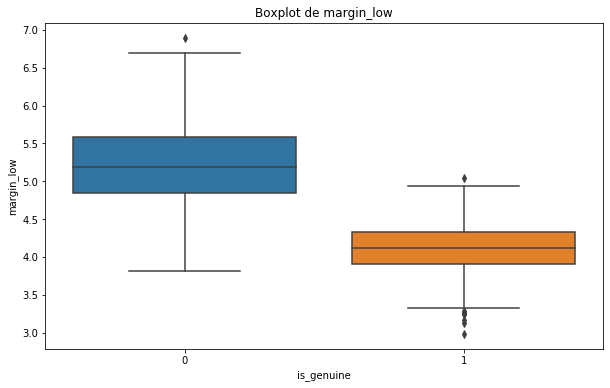

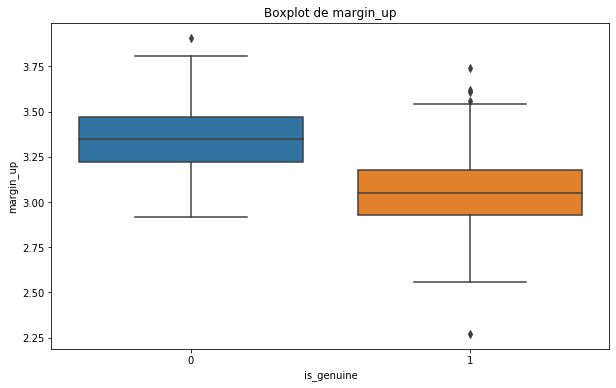

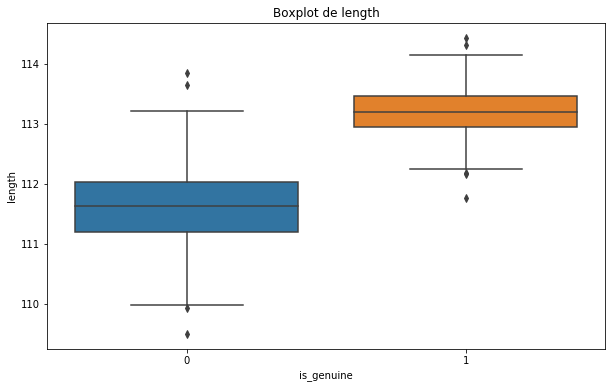

In [39]:
# Dispersion des variables (boxplot)

for col in columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='is_genuine', y=col, data=df)
    plt.title(f'Boxplot de {col}')
    plt.show()

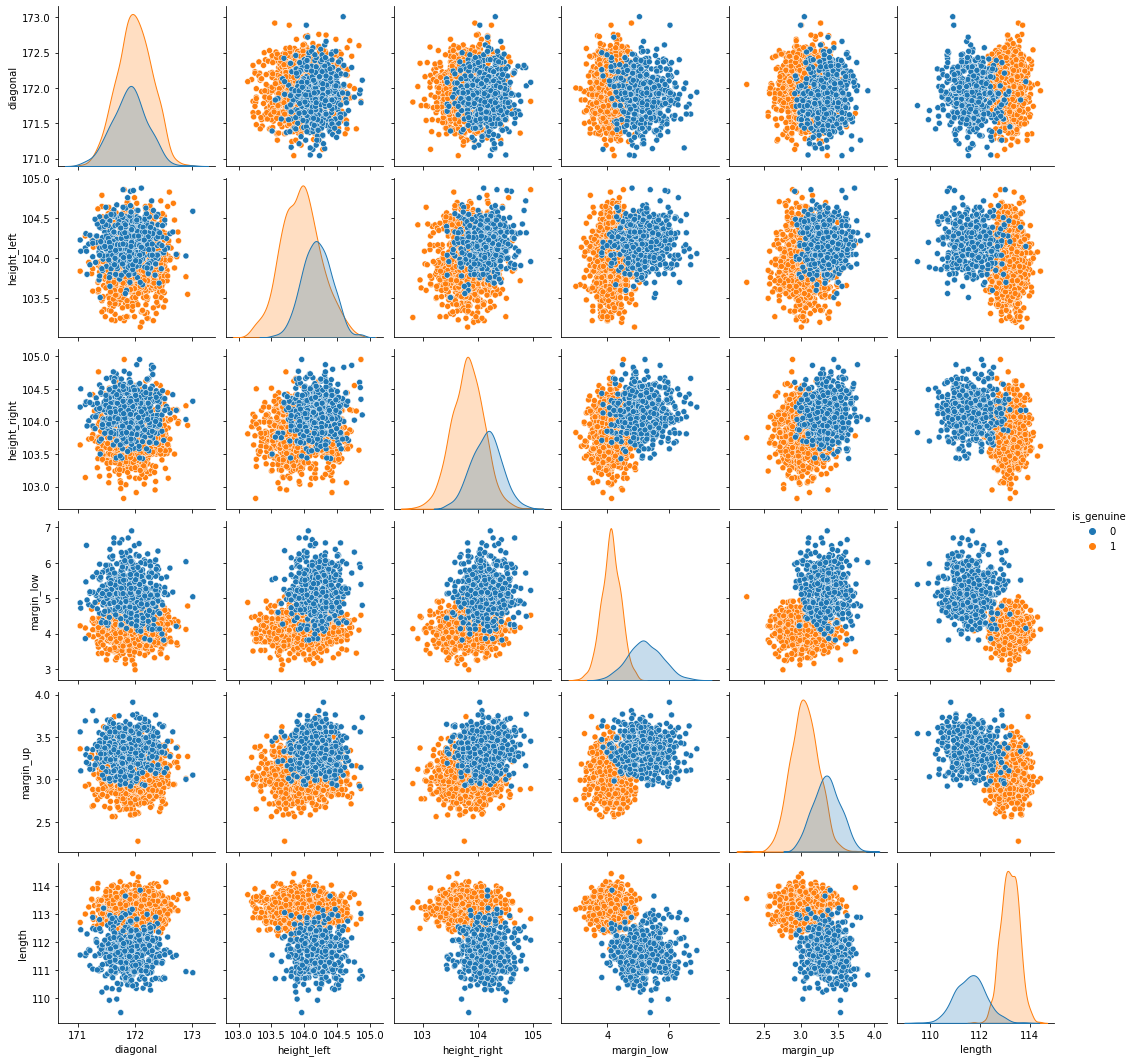

In [40]:
# Distribution des variables par paires en fonction de leur authenticité

sns.pairplot(df, hue='is_genuine')
plt.show()

Il est avéré que les variables **'length'** et **'margin_low'** jouent un rôle clé dans **la distinction** entre **les vrais et faux billets**.

En revanche, la variable **'diagonal'** montre des valeurs **quasi identiques** pour les deux types de billets, ce qui la rend moins discriminante. 

Les **données aberrantes** sont **marginales** et **ne perturbent pas l'analyse**. 

La séparation entre **les groupes de vrais et faux billets** est **nettement observable**, en particulier à travers les variables qui présentent une **forte corrélation**.

## Choix du modèle de détection

### Méthode des K-means VS Régression logistique

In [41]:
# Création d'une fonction pour stocker les résultats des différents modèles testés

def show_metrics(y_true, y_pred, c_label):
    '''Sauvegarde et affiche les métriques dans un dictionnaire.
    Paramètres :
    - y_true : la vraie valeur des labels
    - y_pred : les labels prédits par la méthode de classification
    - c_label : le nom de la méthode de classification
    '''

    # Calcul des métriques et stockage dans un dictionnaire
    metrics_dict = {
        'accuracy': {c_label: metrics.accuracy_score(y_true, y_pred)},
        'precision': {c_label: metrics.precision_score(y_true, y_pred)},
        'recall': {c_label: metrics.recall_score(y_true, y_pred)},
        'f1-score': {c_label: metrics.f1_score(y_true, y_pred)}
    }

    return pd.DataFrame(metrics_dict)

Pour évaluer la performance de manière plus quantitative, nous calculerons les métriques suivantes :

**Accuracy** : L'accuracy mesure la proportion de prédictions correctes (à la fois vraies et fausses) par rapport au total des prédictions faites.

**Précision** : La précision mesure la proportion des identifications positives réelles parmi toutes les identifications positives (vraies positives et fausses positives)

**Rappel** : Le rappel mesure la proportion de vrais positifs par rapport au nombre total d'exemples réels positifs dans les données.

**F1-Score** : Le F1-Score est une mesure qui combine la précision et le rappel en une seule métrique harmonique.


In [42]:
# Préparation des données d'entrainement et de test pour les futurs méthodes testées

# Définit X et y
X = df.drop(columns='is_genuine')
y = df['is_genuine']

# Sépare les données d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

## Régression logistique

**La régression logistique** est une **méthode statistique** qui permet de **modéliser la probabilité** de la présence d'un événement **en fonction de plusieurs variables prédictives**. Elle est utilisée lorsque la variable dépendante est **binaire**, c'est-à-dire qu'elle ne prend que deux valeurs possibles, ici vrai ou faux.

In [43]:
# Effectue la régression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = log_reg.predict(X_test)

# Affiche les coefficients de la régression
for column, coef in zip(X.columns, log_reg.coef_[0]):
    print(f'{column} : \t{coef:>9.6f}')

del column, coef

diagonal : 	-0.272357
height_left : 	-1.393750
height_right : 	-2.040598
margin_low : 	-3.395997
margin_up : 	-2.965148
length : 	 3.817246


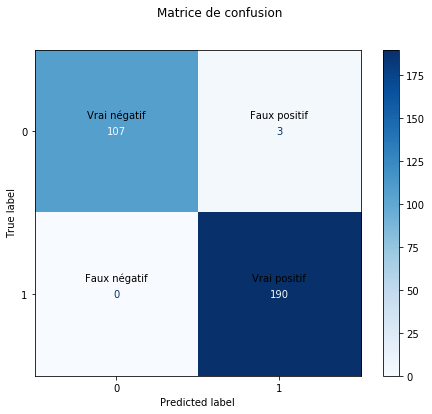

In [44]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(8, 6))

group_names = ['Vrai négatif', 'Faux positif', 'Faux négatif', 'Vrai positif']

labels_positions = [(0,0), (0,1), (1,0), (1,1)]
vertical_offsets = [-0.1, -0.1, -0.1, -0.1]

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

for label, pos, offset in zip(group_names, labels_positions, vertical_offsets):
    i, j = pos
    ax.text(j, i+offset, label, ha='center', va='center', 
            color='black')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [45]:
df_metrics_reglog = show_metrics(y_test, y_pred, 'Logistic regression')

df_metrics_reglog.head()

,accuracy,precision,recall,f1-score
Logistic regression,0.99,0.984456,1.0,0.992167


In [46]:
del y_pred

Le **modèle de régression logistique** présente de **très bonnes performances et résultats**, avec **peu de faux positifs** et **aucun faux négatifs**.

## Méthode des K-means

La **méthode des K-means** est une **technique d'analyse de cluster non supervisée** qui vise à partitionner un ensemble de données en clusters distincts. Dans le contexte d'un modèle prédictif, les **K-means** sont utilisés pour **grouper des observations similaires ensemble**.

Nous aurons, à priori, **2 clusters** : les **vrais** et les **faux** billets.

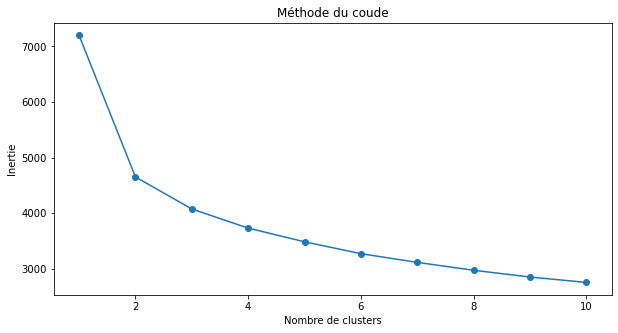

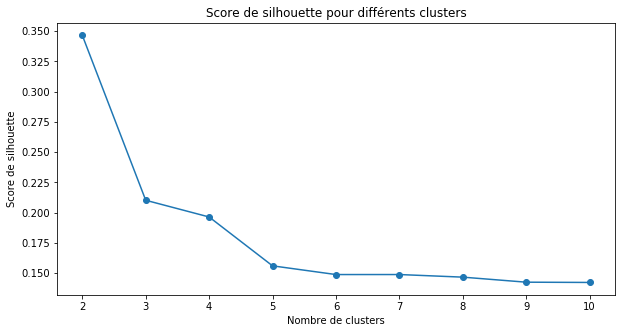

In [47]:
# Normaliser les données d'entraînement
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Méthode du coude
wcss = []
for i in range(1, 11):  # Testons de 1 à 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Score de silhouette
silhouette_scores = []
for i in range(2, 11):  # Le score de silhouette n'est défini que pour 2 clusters ou plus
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualisation de la méthode du coude
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

# Visualisation du score de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Score de silhouette pour différents clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.show()

Sur le graphique de **la méthode du coude**, nous cherchons un point où la courbe **commence à s'aplatir**, indiquant **une diminution marginale de l'inertie** (somme des carrés intra_clusters) en ajoutant plus de clusters. Ce point représente un **équilibre** entre la **précision du modèle et sa complexité**. Ici, la courbe montre une **forte inflexion à 2 clusters**, ce qui suggère qu'ajouter plus de clusters au-delà de 2 n'apporte pas d'amélioration significative à la variance intra-cluster expliquée.

Quant **au score de silhouette**, qui mesure la qualité de séparation des clusters, **une valeur plus élevée** indique que les échantillons sont **mieux adaptés** à leur propre cluster et mal adaptés aux clusters voisins. Dans ce cas, **le score de silhouette** est le **plus élevé pour 2 clusters**, indiquant que c'est le nombre de clusters qui produit les groupes les plus distincts.

In [48]:
# Initialisation du modèle K-Means avec 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')

# Entraînement du modèle K-Means sur les données d'entraînement
kmeans.fit(X_train)

# Prédiction des clusters sur les données de test
clusters_test = kmeans.predict(X_test)

# Conversion des clusters prédits en labels binaires
predicted_labels = clusters_test

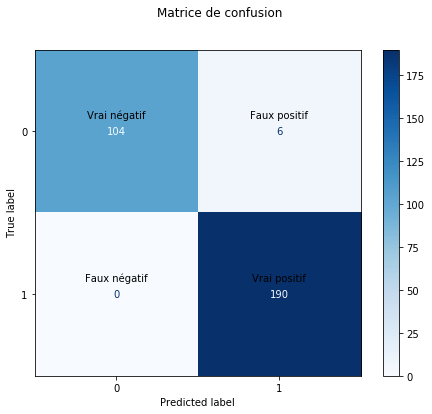

In [49]:
# Tracer la matrice de confusion 
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)

group_names = ['Vrai négatif', 'Faux positif', 'Faux négatif', 'Vrai positif']

labels_positions = [(0,0), (0,1), (1,0), (1,1)]
vertical_offsets = [-0.1, -0.1, -0.1, -0.1]

for label, pos, offset in zip(group_names, labels_positions, vertical_offsets):
    i, j = pos
    ax.text(j, i + offset, label, ha='center', va='center', color='black')

fig.suptitle('Matrice de confusion')

plt.show()

In [50]:
df_metrics_kmeans = show_metrics(y_test, predicted_labels, 'K-means')

df_metrics_kmeans.head()

,accuracy,precision,recall,f1-score
K-means,0.98,0.969388,1.0,0.984456


Le **modèle K-Means** fonctionne très bien **pour identifier les vrais billets** avec une **précision et un rappel élevés**. Cependant, il y a **un petit nombre de faux positifs**, ce qui signifie qu'il y a quelques **faux billets** qui ont été classés **à tort comme vrais**.

### Comparaison des deux modèles : Régression logistique vs K-means

In [51]:
df_comparaison = pd.concat([df_metrics_reglog, df_metrics_kmeans])

df_comparaison.head()

,accuracy,precision,recall,f1-score
Logistic regression,0.99,0.984456,1.0,0.992167
K-means,0.98,0.969388,1.0,0.984456


**Accuracy (Exactitude)**:
- La régression logistique a une précision de 99%, tandis que les k-means ont une précision de 98%. Bien que la différence soit minime, la régression logistique est légèrement plus précise.

**Precision (Précision)**:
- La régression logistique a une précision de 98,4%, contre 96,9% pour les k-means. Cela signifie que la régression logistique a un taux plus faible de faux positifs (prédire un billet comme étant vrai alors qu'il est faux).

**Recall (Rappel ou sensibilité)**:
- Les deux modèles ont un rappel de 100%, ce qui signifie qu'ils identifient tous les vrais billets correctement.

**F1-Score**:
- Le score F1 est une moyenne harmonique de la précision et du rappel. Dans votre cas, la régression logistique a un score F1 de 99,2%, tandis que les k-means ont un score F1 de 98,4%. Cela indique que la régression logistique maintient un équilibre légèrement meilleur entre la précision et le rappel.

En se basant sur **les métriques de performances**, **la régression logistique** semble être **le choix le plus sûr**.

Pour des jeux de données plus importants, il serait intéressant de s'intéresser à la robustesse des modèles comparés et leur vitesse de calcul.

## Test du modèle retenu : la régression logistique

In [52]:
# Sauvegarde du modèle dans un fichier
dump(log_reg, 'new_log_reg_model.joblib')

['new_log_reg_model.joblib']

In [53]:
# Choix du dataframe à tester
df_test = pd.read_csv("billets_production.csv")

df_test.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [54]:
def test_saved_model(df, model):
    # Charger le modèle
    logreg_model = model

    # Préparer les données de test en excluant la colonne 'id'
    X_test = df.drop('id', axis=1)

    # Prédiction sur l'ensemble de test
    y_pred = logreg_model.predict(X_test)

    # Obtenir les probabilités pour chaque classe
    y_proba_true = logreg_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe 'Vrai'
    y_proba_false = logreg_model.predict_proba(X_test)[:, 0] #  Probabilité de la classe 'Faux'

    # Création d'un DataFrame pour les résultats
    results = pd.DataFrame({
        'id': df_test['id'],
        'is_genuine': y_pred,
        'Prob True': y_proba_true,
        'Prob False': y_proba_false
    })

    return results

# model_filename = 'new_log_reg_model.joblib'
test_results = test_saved_model(df_test, log_reg)
test_results.head()

,id,is_genuine,Prob True,Prob False
0,A_1,0,0.005448,0.994552
1,A_2,0,0.001092,0.998908
2,A_3,0,0.001436,0.998564
3,A_4,1,0.918279,0.081721
4,A_5,1,0.999632,0.000368


Les résultats semblent **satisfaisants** car **les variables 'margin_low' et 'length'**, jugées discriminantes, **différencient de manière notable** les vrais et les faux billets de ce dataframe de test.